# **Big Data Machine Learning**

| Nama                    | NRP         |
|-------------------------|-------------|
| Nathan Kho Pancras      | 5027231002  |
| Michael Kenneth Salim   | 5027231008  |
| Fico Simhanandi         | 5027231030  |


## **Import Library**

In [18]:
import kagglehub
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
path = kagglehub.dataset_download("mohammedalsubaie/movies")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\PuroFuro\.cache\kagglehub\datasets\mohammedalsubaie\movies\versions\1


### **Inisiasi Spark Session**

In [20]:
spark = SparkSession.builder.appName("Movies").getOrCreate()

In [21]:
spark

### **Membaca isi data**

In [22]:
df = spark.read.csv(f"{path}/Movies.csv", header=True, inferSchema=True)
pandas_df = pd.read_csv(f"{path}/Movies.csv")

In [23]:
df.printSchema()

root
 |-- movie_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)



In [24]:
df.show(5)

+--------+---------------+------------+----------+--------+------------+----------+-----+---------+---------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|movie_id|          title|vote_average|vote_count|  status|release_date|   revenue|adult|   budget|  imdb_id|original_language| original_title|            overview|          popularity|              genres|production_companies|production_countries|    spoken_languages|
+--------+---------------+------------+----------+--------+------------+----------+-----+---------+---------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 4520010|      Inception|       8.364|     34495|Released|   7/15/2010| 825532764|FALSE|160000000|tt1375666|               en|      Inception|"Cobb, a skilled ...| the implantation...|     

In [25]:
pandas_df.shape

(1048575, 18)

In [26]:
pandas_df.isnull().sum()

movie_id                     0
title                       13
vote_average                 0
vote_count                   0
status                       0
release_date            149422
revenue                      0
adult                        0
budget                       0
imdb_id                 471584
original_language            0
original_title              13
overview                198224
popularity                   0
genres                  402283
production_companies    560686
production_countries    446049
spoken_languages        428440
dtype: int64

In [27]:
df = df.drop('movie_id', 'genres', 'overview', 'imdb_id', 'production_companies', 'production_countries', 'spoken_languages', 'release_date')

In [28]:
panda_df = pandas_df.drop(['movie_id', 'genres', 'overview', 'imdb_id', 'production_companies', 'production_countries', 'spoken_languages', 'release_date'], axis=1, inplace=True)

In [29]:
df.printSchema()

root
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- popularity: string (nullable = true)



In [30]:
pandas_df.isnull().sum()

title                13
vote_average          0
vote_count            0
status                0
revenue               0
adult                 0
budget                0
original_language     0
original_title       13
popularity            0
dtype: int64

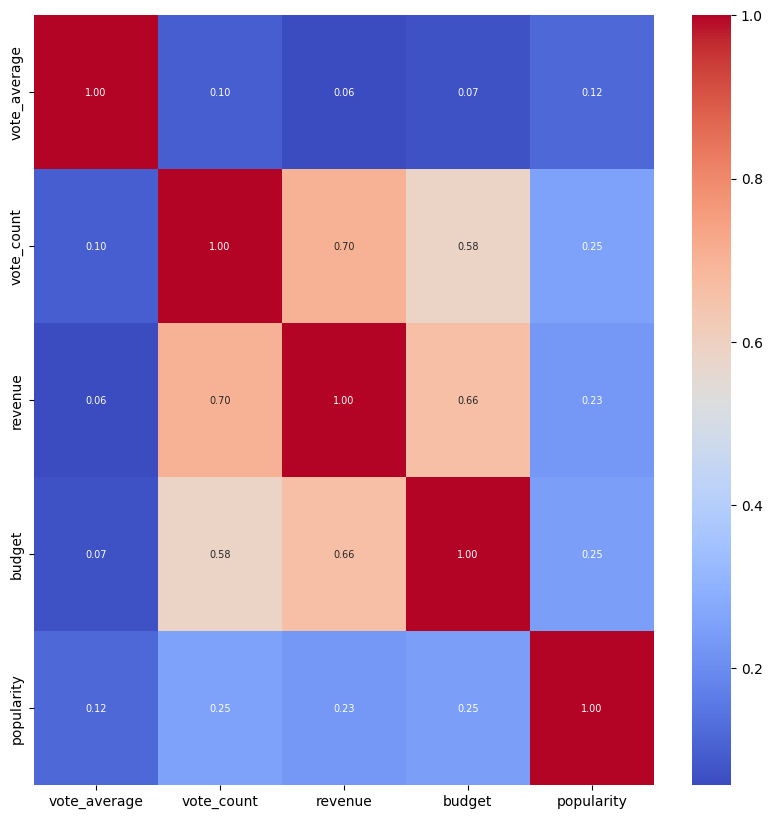

In [31]:
numerical_df = pandas_df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize = (10,10))
sns.heatmap(correlation_matrix, cmap = 'coolwarm', annot=True, fmt=".2f", annot_kws={"size": 7})
plt.show()

In [32]:
pandas_df.head()

,title,vote_average,vote_count,status,revenue,adult,budget,original_language,original_title,popularity
0,Inception,8.364,34495,Released,825532764,False,160000000,en,Inception,83.952
1,Interstellar,8.417,32571,Released,701729206,False,165000000,en,Interstellar,140.241
2,The Dark Knight,8.512,30619,Released,1004558444,False,185000000,en,The Dark Knight,130.643
3,Avatar,7.573,29815,Released,2923706026,False,237000000,en,Avatar,79.932
4,The Avengers,7.710,29166,Released,1518815515,False,220000000,en,The Avengers,98.082


In [33]:
pandas_df['original_language'].unique()

array(['en', 'ko', 'fr', 'ja', 'it', 'es', 'pl', 'pt', 'hi', 'tr', 'da',
       'de', 'cn', 'id', 'zh', 'sv', 'el', 'ru', 'sr', 'fa', 'th', 'ar',
       'no', 'nb', 'fi', 'te', 'la', 'nl', 'hu', 'he', 'is', 'ro', 'gl',
       'uk', 'eu', 'et', 'bs', 'bn', 'xx', 'sh', 'km', 'cs', 'tn', 'ml',
       'mk', 'ga', 'hy', 'ku', 'ka', 'ta', 'kn', 'tl', 'vi', 'ca', 'dz',
       'sw', 'wo', 'kk', 'sk', 'lv', 'mi', 'bo', 'ps', 'mn', 'lt', 'ur',
       'sl', 'sc', 'af', 'hr', 'iu', 'se', 'ms', 'bm', 'mr', 'bg', 'am',
       'lo', 'cy', 'xh', 'qu', 'yi', 'yo', 'pa', 'sq', 'eo', 'gu', 'zu',
       'st', 'ne', 'ak', 'mt', 'as', 'rw', 'ln', 'ay', 'si', 'mo', 'so',
       'ff', 'ky', 'kl', 'ik', 'az', 'ab', 'jv', 'fo', 'li', 'sn', 'my',
       'tg', 'su', 'ks', 'lb', 'ht', 'sm', 'sa', 'tk', 'ha', 'rm', 'fy',
       'bi', 'om', 'gd', 'ny', 'or', 'be', 'uz', 'cr', 'mg', 'mh', 'gn',
       'ia', 'tw', 'co', 'nn', 'nv', 'os', 'tt', 'ug', 'ig', 'dv', 'ty',
       'nd', 'sg', 'kw', 'ba', 'oc', 'ie', 'sd', 'a

In [35]:
# Cast string columns to numeric types
df = df.withColumn("vote_average", df["vote_average"].cast("double"))
df = df.withColumn("vote_count", df["vote_count"].cast("int"))
df = df.withColumn("revenue", df["revenue"].cast("double"))
df = df.withColumn("budget", df["budget"].cast("double"))
df = df.withColumn("popularity", df["popularity"].cast("double"))

# Drop rows with null values in numerical columns
df = df.na.drop(subset=["vote_average", "vote_count", "revenue", "budget", "popularity"])

# Get numerical columns after casting
numerical_cols = ["vote_average", "vote_count", "revenue", "budget", "popularity"]
print("Numerical columns:", numerical_cols)

# Create feature vector with handleInvalid="skip" to handle any remaining null values
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features_unscaled", handleInvalid="skip")
df_vector = assembler.transform(df)

# Scale features
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features_scaled", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

Numerical columns: ['vote_average', 'vote_count', 'revenue', 'budget', 'popularity']


In [ ]:
spark.stop()